In [3]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
from musc_genomics import data
from musc_genomics.data_modeling import modeling, features, prepared
from ml.model import models as ml_model
from ml.model import summaries as ml_precis
pd.set_option('max_info_rows', 10000)

2016-08-06 08:30:18,627:INFO:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [8]:
d, na_summary, fill_summary, imp_summary = prepared.get_modeling_data_01('maximal')

2016-08-06 08:31:18,047:DEBUG:research.project.manager: Loading saved data from location "/Users/eczech/data/research/musc_genomics/features/encode_maximal.pkl"
/Users/eczech/repos/musc_genomics/src/python/src/musc_genomics/data_modeling/features.py:110: PerformanceWarning:

indexing past lexsort depth may impact performance.



In [9]:
d.filter(regex='RES:').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 381 entries, (22RV1, urogenital_system, prostate) to (ZR7530, breast, breast)
Data columns (total 6 columns):
RES:VAL:ABT-263       381 non-null float64
RES:VAL:AG-014699     381 non-null float64
RES:VAL:NUTLIN-3A     381 non-null float64
RES:VAL:PD-0332991    381 non-null float64
RES:VAL:PLX4720       381 non-null float64
RES:VAL:SB590885      381 non-null float64
dtypes: float64(6)
memory usage: 20.8+ KB


In [10]:
responses = d.filter(regex='RES:').columns.tolist()
X, Y = d.drop(responses, axis=1), d[responses]

In [11]:
d.filter(regex='^CL:').std().describe()

count    48.000000
mean      0.179989
std       0.125413
min       0.000000
25%       0.072357
50%       0.156073
75%       0.246686
max       0.500449
dtype: float64

In [31]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.cross_validation import KFold
from xgboost import XGBRegressor

cv = KFold(len(Y), 10, shuffle=True, random_state=1)

clf_rf = Pipeline([
    ('filter', VarianceThreshold(threshold=.05)),
    ('clf', RandomForestRegressor())
])
clf_etr = Pipeline([
    ('filter', VarianceThreshold(threshold=.05)),
    ('clf', ExtraTreesRegressor())
])
clf_lasso = Pipeline([
    ('filter', VarianceThreshold(threshold=.05)),
    ('scale', StandardScaler()),
    ('clf', MultiTaskLassoCV())
])

clfs = {
    'rf': clf_rf,
    'etr': clf_etr,
    'lasso': clf_lasso,
    'baseline': DummyRegressor()
}

n_jobs = 1 # Do not change this, change n_jobs in models instead
cv_res, refit_res = ml_model.run_models(
    X, Y, clfs, cv, 'regressor', 
    keep_training_data=False, par_n_jobs=n_jobs, 
    refit=True
)

2016-07-25 07:18:24,602:INFO:ml.model.log: Running model rf (Pipeline) on fold 1 ==> dim(train) = (342, 73244), dim(test) = (39, 73244)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2016-07-25 07:19:24,323:INFO:ml.model.log: Running model lasso (Pipeline) on fold 1 ==> dim(train) = (342, 73244), dim(test) = (39, 73244)
2016-07-25 07:26:35,411:INFO:ml.model.log: Running model etr (Pipeline) on fold 1 ==> dim(train) = (342, 73244), dim(test) = (39, 73244)
2016-07-25 07:27:07,055:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(train) = (342, 73244), dim(test) = (39, 73244)
2016-07-25 07:27:07,223:INFO:ml.model.log: Running model rf (Pipeline) on fold 2 ==> dim(train) = (343, 73244), dim(test) = (38, 73244)
2016-07-25 07:28:09,684:INFO:ml.model.log: Running model lasso (Pipeline) on fold 2 ==> dim(train) = (343, 73244), dim(test) = (38, 73244)
2016-07-25 07:37:27,773:INFO:ml.model.log: Running model etr (Pipeline) on fold 2 ==> dim(train) = (343, 73244), dim(test) = (38, 73244)
2016-07-25 07:37:56,218:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 2 ==> dim(train) = (343, 73244), dim(test) = (38, 73244)
2016-07-25 07:37

In [4]:
#data.save('modeling', 'multi_task_models', (cv_res, refit_res))
(cv_res, refit_res) = data.load('modeling', 'multi_task_models')

2016-08-06 08:30:21,512:DEBUG:research.project.manager: Loading saved data from location "/Users/eczech/data/research/musc_genomics/modeling/multi_task_models.pkl"


In [37]:
from ml.model import importances

def feat_imp_pipeline(clf):
    cols = X.columns
    assert cols.shape == clf.named_steps['filter'].get_support().shape
    cols = cols[clf.named_steps['filter'].get_support()]
    
    res = importances.get_regressor_fi(clf, cols)
    return res

feat_imp_calc = {
    'rf': feat_imp_pipeline
}
feat_imp = ml_model.summarize_importances([refit_res], feat_imp_calc=feat_imp_calc)
ml_precis.plot_feature_importance([refit_res], limit=35, feat_imp_calc=feat_imp_calc)

In [38]:
feat_imp.drop(['model_name', 'fold_id'], axis=1).T[0].sort_values(ascending=False).reset_index()\
    .rename(columns={0: 'IMP'}).assign(RANK=lambda x: x['IMP'].rank(ascending=False))\
    .set_index('FEATURE')\
    .filter(regex='^CL:', axis=0)
    #.pipe(lambda x: x[x['FEATURE'].str.startswith('MU:')])


,IMP,RANK
FEATURE,,
CL:HISTOLOGY:malignant_melanoma,0.007615,17.0
CL:GENDER:male,0.000173,932.0
CL:GENDER:unknown,0.000000,19570.0
CL:PRIMARY_SITE:breast,0.000000,19570.0
CL:PRIMARY_SITE:central_nervous_system,0.000000,19570.0
CL:PRIMARY_SITE:haematopoietic_and_lymphoid_tissue,0.000000,19570.0
CL:PRIMARY_SITE:large_intestine,0.000000,19570.0
CL:PRIMARY_SITE:lung,0.000000,19570.0
CL:PRIMARY_SITE:skin,0.000000,19570.0


In [12]:
d_pred = ml_model.summarize_predictions(cv_res, y_names=Y.columns.tolist())
d_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524 entries, 0 to 37
Data columns (total 14 columns):
y_pred_RES:VAL:ABT-263       1524 non-null float64
y_true_RES:VAL:ABT-263       1524 non-null float64
y_pred_RES:VAL:AG-014699     1524 non-null float64
y_true_RES:VAL:AG-014699     1524 non-null float64
y_pred_RES:VAL:NUTLIN-3A     1524 non-null float64
y_true_RES:VAL:NUTLIN-3A     1524 non-null float64
y_pred_RES:VAL:PD-0332991    1524 non-null float64
y_true_RES:VAL:PD-0332991    1524 non-null float64
y_pred_RES:VAL:PLX4720       1524 non-null float64
y_true_RES:VAL:PLX4720       1524 non-null float64
y_pred_RES:VAL:SB590885      1524 non-null float64
y_true_RES:VAL:SB590885      1524 non-null float64
model_name                   1524 non-null object
fold_id                      1524 non-null int64
dtypes: float64(12), int64(1), object(1)
memory usage: 178.6+ KB


In [13]:
d_pp = d_pred.assign(row_id=np.arange(len(d_pred)))\
    .set_index(['model_name', 'fold_id', 'row_id']).rename_axis('drug', axis=1)\
    .stack(dropna=False).rename('value').reset_index()\
    .assign(type=lambda x: x['drug'].apply(lambda v: '_'.join(v.split('_')[:2])))\
    .assign(drug_name=lambda x: x['drug'].str.split(':').str[-1])\
    .drop('drug', axis=1)
    
idx_cols = np.setdiff1d(d_pp.columns.tolist(), ['value'])
d_pp = d_pp.set_index(list(idx_cols))['value'].unstack('type').reset_index()
d_pp.columns.name = None
d_pp.head()

,drug_name,fold_id,model_name,row_id,y_pred,y_true
0,ABT-263,1,baseline,117,2.42935,4.510450
1,ABT-263,1,baseline,118,2.42935,-2.093952
2,ABT-263,1,baseline,119,2.42935,1.359720
3,ABT-263,1,baseline,120,2.42935,0.182912
4,ABT-263,1,baseline,121,2.42935,-0.106215


In [144]:
data.save('modeling', 'multi_task_pred', d_pp)

2016-07-25 13:03:21,051:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/modeling/multi_task_pred.pkl"


'/Users/eczech/data/research/musc_genomics/modeling/multi_task_pred.pkl'

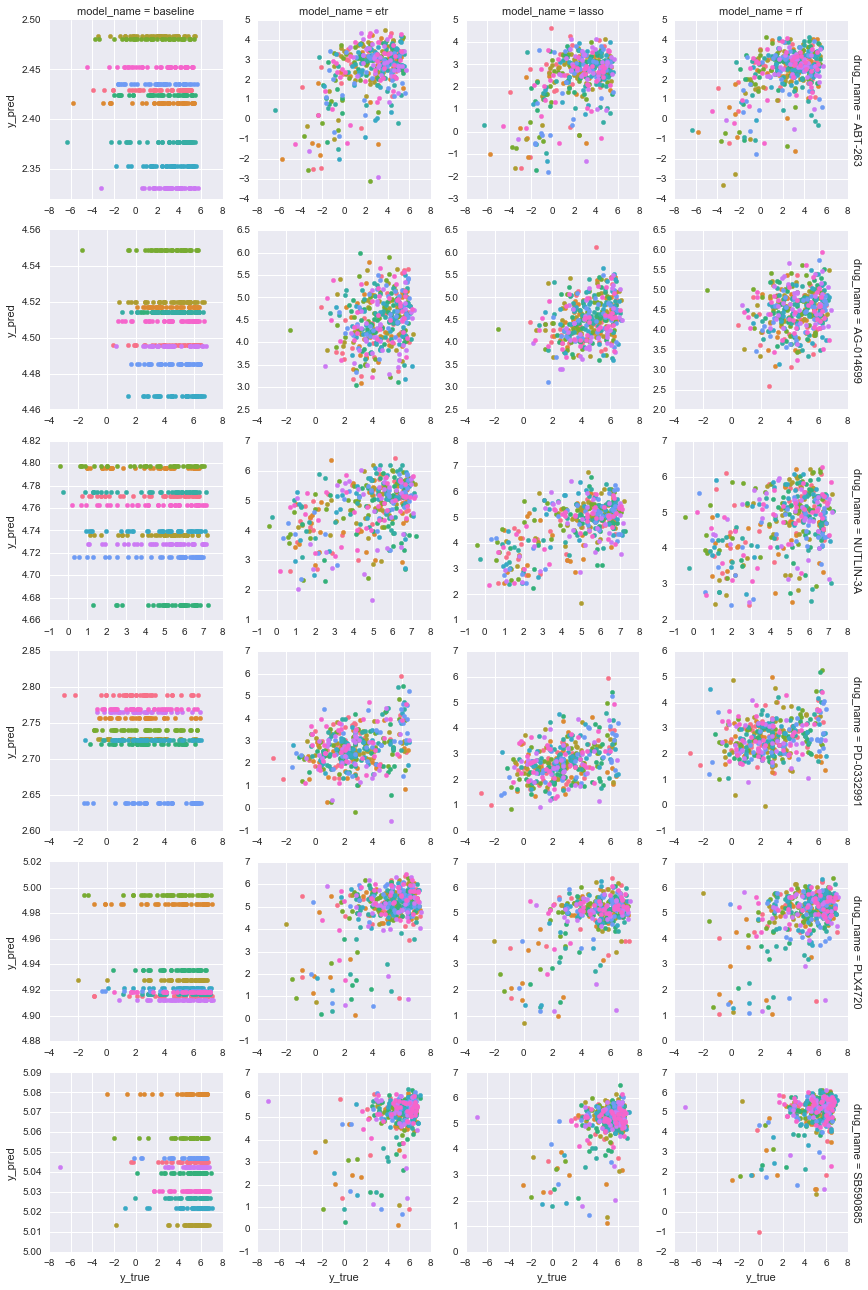

In [145]:
g = sns.FacetGrid(
    d_pp, row='drug_name', col='model_name', hue='fold_id', 
    margin_titles=True, sharex=False, sharey=False
)
g.map(plt.scatter, 'y_true', 'y_pred')

In [14]:
from sklearn.metrics import r2_score
def get_score(g):
    #return r2_score(g['y_true'], g['y_pred'])
    return g['y_true'].corr(g['y_pred'])**2
d_perf = d_pp.groupby(['model_name', 'drug_name', 'fold_id']).apply(get_score)\
    .rename('score').reset_index()
d_perf.head()

,model_name,drug_name,fold_id,score
0,baseline,ABT-263,1,4.735916e-33
1,baseline,ABT-263,2,5.051089e-34
2,baseline,ABT-263,3,2.776189e-34
3,baseline,ABT-263,4,NaN
4,baseline,ABT-263,5,1.363793e-33


In [15]:
data.save('modeling', 'multi_task_perf', d_perf)

2016-08-06 08:31:35,342:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/modeling/multi_task_perf.pkl"


'/Users/eczech/data/research/musc_genomics/modeling/multi_task_perf.pkl'

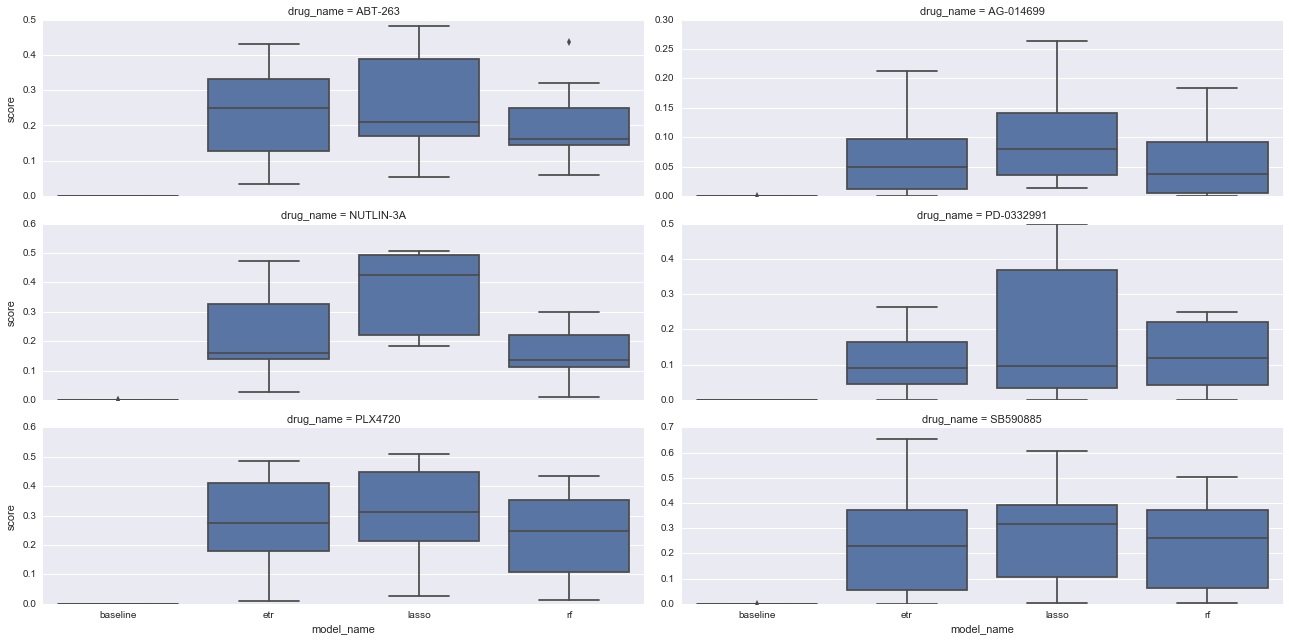

In [16]:
plt.figure(figsize=(8,12))
sns.FacetGrid(d_perf, col='drug_name', size=3, aspect=3, sharey=False, col_wrap=2)\
    .map(sns.boxplot, 'model_name', 'score')

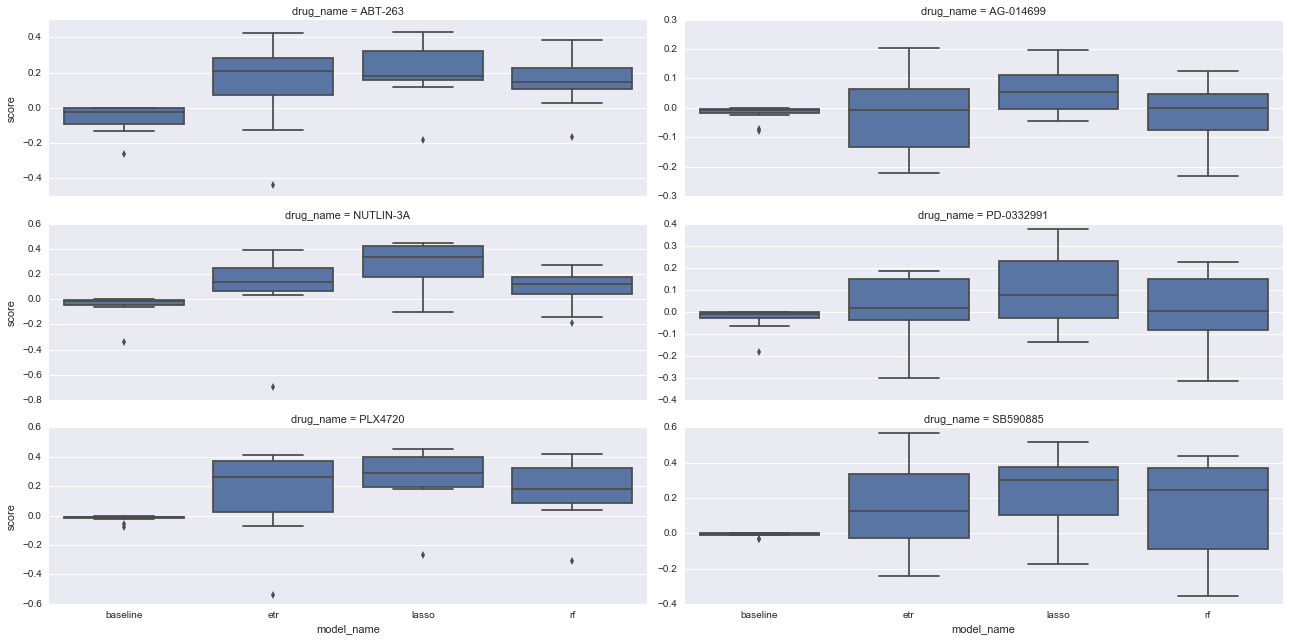

In [150]:
plt.figure(figsize=(8,12))
sns.FacetGrid(d_perf, col='drug_name', size=3, aspect=3, sharey=False, col_wrap=2)\
    .map(sns.boxplot, 'model_name', 'score')